## Импорт библиотек

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

## Знакомство с данными

In [3]:
labels_path = 'data/labels.npy'
images_path = 'data/images.npy'

labels = np.load(labels_path)
images = np.load(images_path)
display(labels.shape)
display(images.shape)

(20000,)

(20000, 48, 48, 3)

In [6]:
# Создаем словарь, для удобства проверки качества классификации
glossary = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',
            10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
            18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}

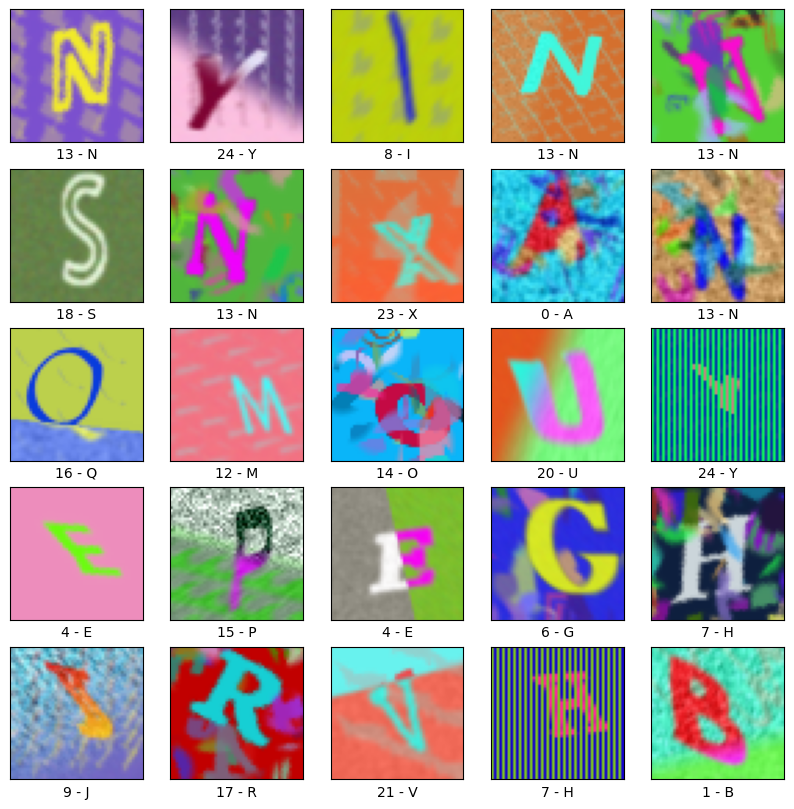

In [19]:
# Посмотрим примеры картинок для классификации
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(str(labels[i]) + ' - ' + glossary[labels[i]])
plt.show()

## Подготовка данных к обучению

In [7]:
# Посмотрим на распределение меток
unique_labels, counts = np.unique(labels, return_counts=True)
print(f'Количество каждого класса: {counts}')

Количество каждого класса: [ 748  878  710  880  764  677  816  904  440  497  794  512  972  921
  871  759  866  929  739  575  763  739 1013  816  682  735]


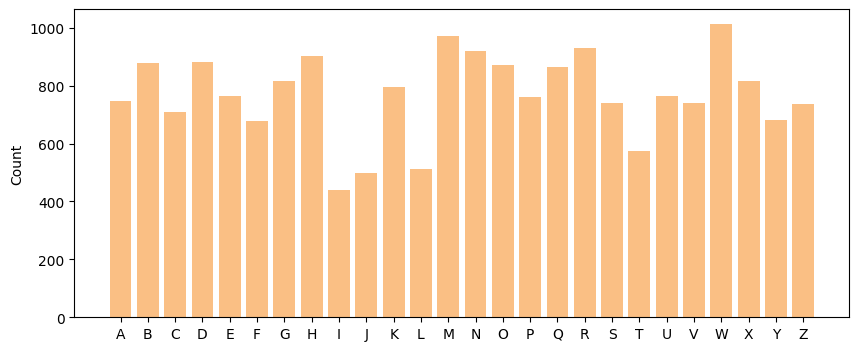

In [8]:
# Посмотрим на распределение меток на графике
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(list(glossary.values()), counts, color='#fabf84')
ax.set_ylabel('Count')

plt.show()

Как видно в данных присутствует дисбаланс, это может вызвать трудности при обучении, создадим словарь состоящий из индекса класса и его веса, сгенерированного при помощи функции `compute_class_weight`. Это уравняет наши метки классов по значимости

In [9]:
# Создание словаря с весами классов
class_weights = compute_class_weight('balanced', classes=unique_labels, y=labels)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.0283833813245578,
 1: 0.8761170492377782,
 2: 1.0834236186348862,
 3: 0.8741258741258742,
 4: 1.0068465565847764,
 5: 1.1362345188046812,
 6: 0.942684766214178,
 7: 0.8509189925119128,
 8: 1.7482517482517483,
 9: 1.547748026621266,
 10: 0.968804495252858,
 11: 1.5024038461538463,
 12: 0.7913896802785692,
 13: 0.8352125615969265,
 14: 0.8831581736288969,
 15: 1.0134792743488397,
 16: 0.8882572392965002,
 17: 0.8280202036929701,
 18: 1.0409076714895389,
 19: 1.3377926421404682,
 20: 1.0081661457808246,
 21: 1.0409076714895389,
 22: 0.7593591009188245,
 23: 0.942684766214178,
 24: 1.1279043537108053,
 25: 1.0465724751439036}

Также добавим в наши данные аугменацию, для увеличение выборки

In [10]:
datagen = ImageDataGenerator(
   rotation_range=20,          # Поворот на случайный угол до 20 градусов
   zoom_range=0.2,            # Увеличение размера до 20 %
   width_shift_range=0.1,      # Сдвих влево / вправо до 10 процентов
   height_shift_range=0.1,     # Сдвиг вверх / вниз до 10 процентов
)

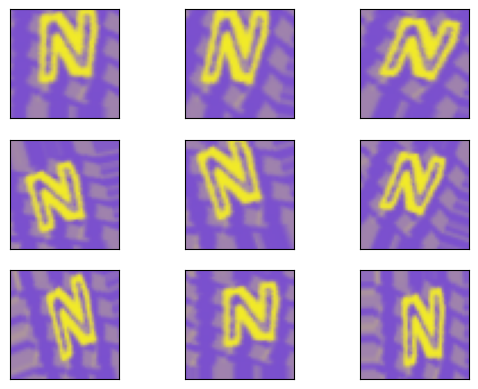

In [24]:
# Посмотрим на возможные результаты аугментации
it = datagen.flow(images[0:1])

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  batch = it.next()
  image = batch[0].astype('uint8')
  plt.imshow(image)

plt.show()

In [11]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)
print(f'Размер обучающей выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

Размер обучающей выборки: (16000, 48, 48, 3)
Размер тестовой выборки: (4000, 48, 48, 3)


In [12]:
# Центрируем и нормируем данные
x_train_float = X_train.astype(float) / 255 - 0.5
x_test_float = X_test.astype(float) / 255 - 0.5
print(x_train_float[1, 1, 10:15])
print(x_test_float[1, 1, 10:15])

[[ 0.37843137 -0.04117647 -0.1745098 ]
 [ 0.37843137 -0.04117647 -0.1745098 ]
 [ 0.37843137 -0.04117647 -0.1745098 ]
 [ 0.37843137 -0.04117647 -0.1745098 ]
 [ 0.37843137 -0.04117647 -0.1745098 ]]
[[ 0.27647059 -0.02156863 -0.19019608]
 [ 0.26470588  0.04117647 -0.19411765]
 [ 0.2372549   0.12352941 -0.20196078]
 [ 0.22156863  0.20196078 -0.18627451]
 [ 0.22941176  0.28039216 -0.13137255]]


In [13]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 26)
y_test_oh = keras.utils.to_categorical(y_test, 26)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(16000, 26)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0.]] [20 22 14 14 22]


## Создание и обучение модели

In [50]:
clear_session()

In [51]:
model = Sequential()
model.add(Input((48, 48, 3)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2))),
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(26, activation='softmax'))

In [52]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',
    metrics=['accuracy'],# выводим процент правильных ответов
)

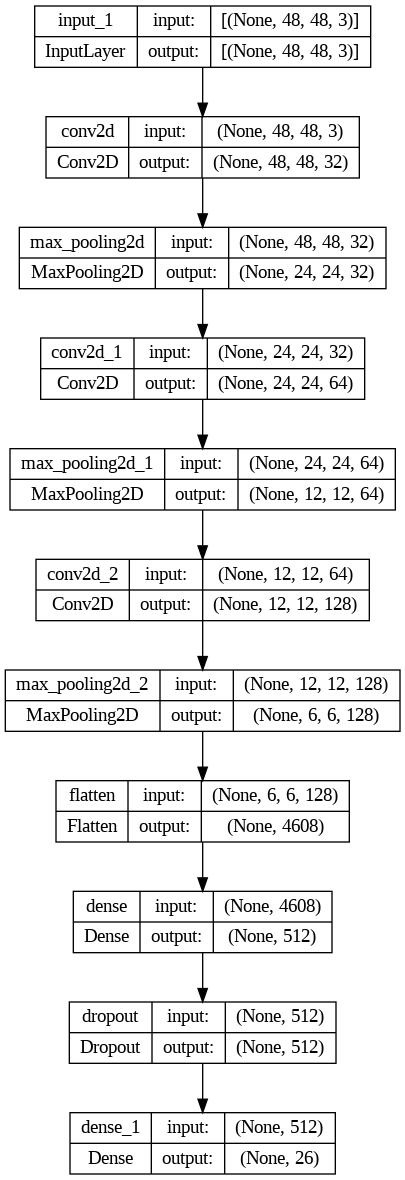

In [53]:
# Визуализируем модель
plot_model(model, show_shapes = True)

In [54]:
# Обучаем модель
history = model.fit(
    datagen.flow(x_train_float, y_train_oh),
    batch_size=64,
    epochs=20,
    class_weight=class_weights,
    validation_data=(x_test_float[:, :, :, :, np.newaxis], y_test_oh)
)

Epoch 1/20
500/500 [==============================] - 123s 241ms/step - loss: 3.2432 - accuracy: 0.0457 - val_loss: 2.9411 - val_accuracy: 0.1305
Epoch 2/20
500/500 [==============================] - 121s 242ms/step - loss: 2.3189 - accuracy: 0.3187 - val_loss: 1.2309 - val_accuracy: 0.6255
Epoch 3/20
500/500 [==============================] - 120s 240ms/step - loss: 1.5526 - accuracy: 0.5316 - val_loss: 0.8760 - val_accuracy: 0.7370
Epoch 4/20
500/500 [==============================] - 120s 240ms/step - loss: 1.2481 - accuracy: 0.6233 - val_loss: 0.7522 - val_accuracy: 0.7720
Epoch 5/20
500/500 [==============================] - 125s 249ms/step - loss: 1.0939 - accuracy: 0.6637 - val_loss: 0.5845 - val_accuracy: 0.8192
Epoch 6/20
500/500 [==============================] - 121s 242ms/step - loss: 0.9863 - accuracy: 0.6989 - val_loss: 0.5351 - val_accuracy: 0.8370
Epoch 7/20
500/500 [==============================] - 123s 246ms/step - loss: 0.9152 - accuracy: 0.7170 - val_loss: 0.5099 -

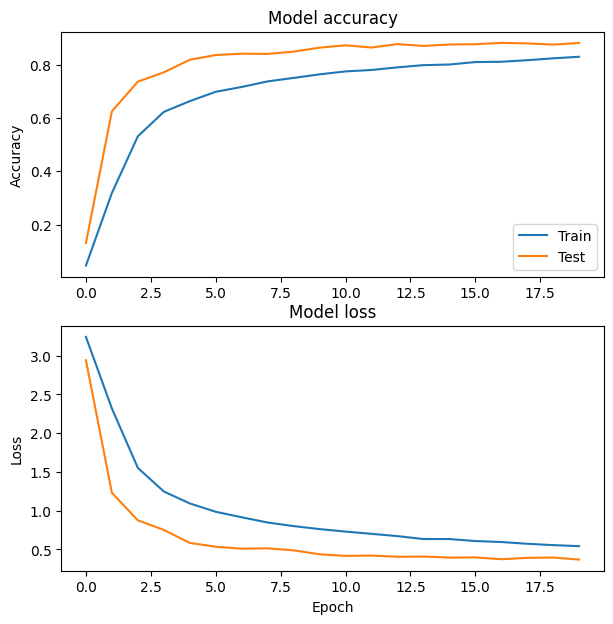

In [55]:
# Построим график точности в зависимости от эпохи
plt.style.use(['default'])
fig, ax = plt.subplots(figsize=(7,7), nrows=2, ncols=1)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Test'], loc='lower right')

# Построим график потерь в зависимости от эпохи
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
plt.show()

Судя по данным, модель еще может улучшить свои показатели, пока что растут и train accuracy и test accuracy, попробуем дообучить модель еще на 20 эпохах и посмотрим на результаты.

In [15]:
# По необходимости можно подгрузить модель
#model = keras.models.load_model('models/mipt_сapcha_model.keras')

In [16]:
# Дообучаем модель
history = model.fit(
    datagen.flow(x_train_float, y_train_oh),
    batch_size=64,
    epochs=20,
    class_weight=class_weights,
    validation_data=(x_test_float[:, :, :, :, np.newaxis], y_test_oh)
)

Epoch 1/20
500/500 [==============================] - 130s 256ms/step - loss: 0.5437 - accuracy: 0.8261 - val_loss: 0.3538 - val_accuracy: 0.8932
Epoch 2/20
500/500 [==============================] - 124s 247ms/step - loss: 0.5255 - accuracy: 0.8356 - val_loss: 0.3596 - val_accuracy: 0.8870
Epoch 3/20
500/500 [==============================] - 121s 242ms/step - loss: 0.5186 - accuracy: 0.8325 - val_loss: 0.3585 - val_accuracy: 0.8855
Epoch 4/20
500/500 [==============================] - 134s 267ms/step - loss: 0.5020 - accuracy: 0.8371 - val_loss: 0.3449 - val_accuracy: 0.8890
Epoch 5/20
500/500 [==============================] - 126s 251ms/step - loss: 0.4868 - accuracy: 0.8439 - val_loss: 0.3620 - val_accuracy: 0.8923
Epoch 6/20
500/500 [==============================] - 119s 238ms/step - loss: 0.4791 - accuracy: 0.8475 - val_loss: 0.3357 - val_accuracy: 0.8985
Epoch 7/20
500/500 [==============================] - 123s 247ms/step - loss: 0.4623 - accuracy: 0.8541 - val_loss: 0.3425 -

In [17]:
# Сохраним полученную модель
model.save('models/mipt_сapcha_model.keras')

Видно небольшое улучшение, возможно можно еще дообучить модель, но количество потраченного времени не стоит того прироста качества, которое мы получаем в результате.

## Получение предсказания для сабмита

In [18]:
# Загрузим данные и нормализуем их
images_sub_path = 'data/images_sub.npy'
images_sub = np.load(images_sub_path)

images_sub_float = images_sub.astype(float) / 255 - 0.5

In [19]:
# Сделаем предсказание
predicts=model.predict(images_sub_float)
classes_x=np.argmax(predicts,axis=1)

1563/1563 [==============================] - 80s 51ms/step


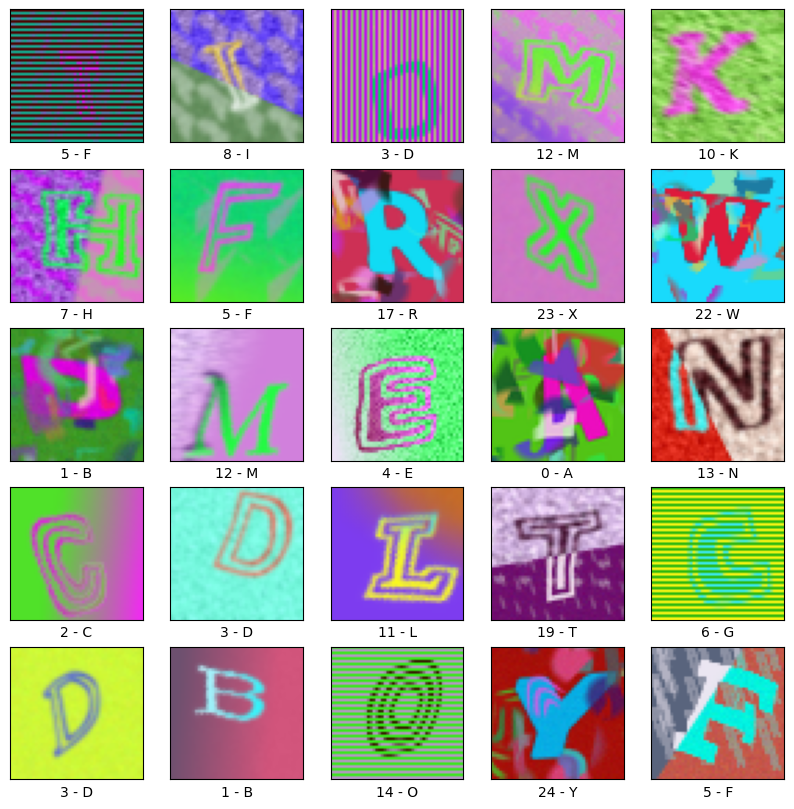

In [20]:
# Посмотрим на качество классификации
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_sub[i])
    x_lab = f'{classes_x[i]} - {glossary[classes_x[i]]}'
    plt.xlabel(x_lab)
plt.show()

In [21]:
# Сохраним полученное предсказание
id = np.arange(images_sub.shape[0])
result = pd.DataFrame({
    'Id': id,
    'Category': classes_x
})
result_path = 'data/result_capcha.csv'
result.to_csv(result_path, index=False)